In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [2]:
L=2

dim = np.zeros((L+1,))

dim[0] = 100
dim[1] = 70
dim[2] = 40
#dim[3] = 10
#dim[4] = 50
#dim[5] = 50
#dim[6] = 50
#dim[7] = 50
#dim[8] = 50
#dim[9] = 50
#dim[10] = 50

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 5000
num_test_data = 5000

noise = 0.0

num_models = 10





9800


### Create Neural Network

In [3]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1./np.sqrt(y)) 
        #nn.init.normal_(m.weight, mean=0.0, std=1.) 


        
        
nets = []
nets0 = []

for _ in range(num_models):
    
    # Create a new model and initialize its weights
    net = Net()
    net.apply(initialize_weights)
    nets.append(net)
    
    # Create a "backup" of the initial weights
    net0 = Net()
    net0.load_state_dict(net.state_dict())  # Copy weights
    nets0.append(net0)



net_teacher = Net()
net_teacher.apply(initialize_weights)

'''
net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())
'''

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


9800


In [ ]:
# print list of all parameter tensors

print(list(nets[0].parameters()))

print(list(nets0[0].parameters()))


### Save model

In [ ]:
#PATH = './mlp_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)

#PATH = './mlp_up_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_up_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)


### Load model

In [ ]:

PATH = './mlp_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))


'''
PATH = './mlp_up_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_up_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))
'''

### Input data

In [4]:
# gradient on linear regression has D ~ (unif)^(1/(1-beta)) --> p(D) ~ D^(-beta) --> Loss(t) ~ t^(beta-2)

D = np.logspace(0,-5,dim[0])
#D = 1./(np.linspace(1,1000,dim[0])**2)
#D = np.linspace(0,1,dim[0])**2

Sigma, R = np.linalg.qr(np.random.normal(np.zeros((dim[0],dim[0])),1))
Sigma = (Sigma * D) @ Sigma.T
inputs_train = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_train_data,))).to(torch.float)
inputs_test = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_test_data,))).to(torch.float)






### Save input

In [ ]:
#PATH = './mlp_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_inputs_test.pth'
#torch.save(inputs_test, PATH)

#PATH = './mlp_up_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_up_inputs_test.pth'
#torch.save(inputs_test, PATH)



### Load input

In [ ]:

PATH = './mlp_inputs_train.pth'
inputs_train = torch.load(PATH)
PATH = './mlp_inputs_test.pth'
inputs_test = torch.load(PATH)


#PATH = './mlp_up_inputs_train.pth'
#inputs_train = torch.load(PATH)
#PATH = './mlp_up_inputs_test.pth'
#inputs_test = torch.load(PATH)


### Output data

In [5]:

with torch.no_grad():
    labels_train = net_teacher(inputs_train) + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
with torch.no_grad():
    labels_test = net_teacher(inputs_test) + torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)


### Fit linear model

In [6]:

Wlin = labels_train.T @ np.linalg.pinv(inputs_train).T
outputs_train_lin = ( Wlin @ inputs_train.T ).T
outputs_test_lin = ( Wlin @ inputs_test.T ).T

trainloss_lin = np.linalg.norm(outputs_train_lin-labels_train)**2 / num_train_data / 2
testloss_lin = np.linalg.norm(outputs_test_lin-labels_test)**2 / num_test_data / 2


In [7]:

print(trainloss_lin)
#print('\n')
print(testloss_lin)


0.005782024450632548
0.00626071114337376


### Learning rate

In [8]:

lr = .8
nepochs_gd = 1000


### Reset

In [ ]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, gradient descent

In [10]:

rec_time = 1
nitera = int(nepochs_gd/rec_time)

running_trainloss_gd = torch.zeros( (nitera,num_models) )
running_testloss_gd = torch.zeros( (nitera,num_models) )


phi_rec = np.zeros((L-2,nepochs_gd,num_models+1))
PHI1_rec = np.zeros((dim[0],dim[0],nepochs_gd,num_models+1))
PHIL_rec = np.zeros((dim[L],dim[L],nepochs_gd,num_models+1))

if L==2:
    PSI1_rec = np.zeros((dim[0],dim[2],nepochs_gd,num_models+1))
else:
    PSI1_rec = np.zeros((0,0,nepochs_gd,num_models+1))

grad_rec = np.zeros((num_parameters,nitera,num_models))

#itera = 0    

for epoch in range(nepochs_gd):  # loop over the dataset multiple times

    if epoch%(nepochs_gd/100) == 0:
        print(epoch)
    #itera += 1

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss_gd[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss_gd[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)
        grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
        grad_vec_C = torch.cat([g.view(-1) for g in grads])

        grad_np = grad_vec_F.numpy()
        grad_rec[:,epoch,inet] = grad_np.reshape((num_parameters,))
        phi_rec[:,epoch,inet],PHI1_rec[:,:,epoch,inet],PSI1_rec[:,:,epoch,inet],PHIL_rec[:,:,epoch,inet] = sm.grad2par(L,dim,grad_np)
        
        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * grad_vec_C , nets[inet].parameters())    
        
    phi_rec[:,epoch,num_models],PHI1_rec[:,:,epoch,num_models],PSI1_rec[:,:,epoch,num_models],PHIL_rec[:,:,epoch,num_models] = sm.grad2par(L,dim,np.squeeze(grad_rec[:,epoch,:]))

print('Finished Training')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Finished Training


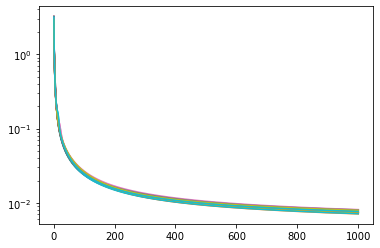

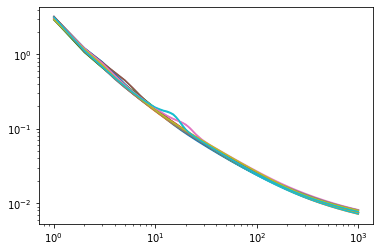

In [11]:

plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


plt.plot(np.arange(1,nepochs_gd+1),running_trainloss_gd)
plt.plot(np.arange(1,nepochs_gd+1),running_testloss_gd)
plt.xscale('log')
plt.yscale('log')

plt.show()



In [13]:

eigrec = np.zeros((dim[0]+(L-2)+dim[L],nepochs_gd,num_models+1))
for epoch in range(nepochs_gd):
    if epoch%(nepochs_gd/100) == 0:
        print(epoch)
    for inet in range(num_models):
        eigrec[:,epoch,inet] = sm.eig_unique(L,dim,np.reshape(phi_rec[:,epoch,inet],(L-2,)),np.squeeze(PHI1_rec[:,:,epoch,inet]),np.squeeze(PSI1_rec[:,:,epoch,inet]),np.squeeze(PHIL_rec[:,:,epoch,inet]))
    eigrec[:,epoch,num_models] = sm.eig_unique(L,dim,np.reshape(phi_rec[:,epoch,num_models],(L-2,)),np.squeeze(PHI1_rec[:,:,epoch,num_models]),np.squeeze(PSI1_rec[:,:,epoch,num_models]),np.squeeze(PHIL_rec[:,:,epoch,num_models]))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


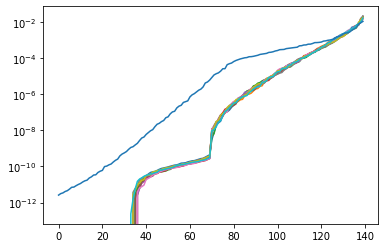

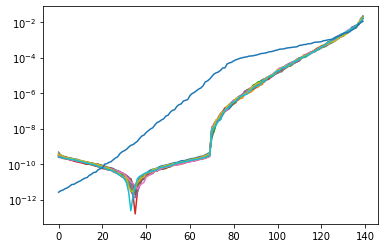

In [14]:

epoch = 0

for inet in range(num_models):
    plt.plot(eigrec[:,epoch,inet])
plt.plot(eigrec[:,epoch,num_models])
plt.yscale('log')
plt.show()

for inet in range(num_models):
    plt.plot(np.abs(eigrec[:,epoch,inet]))
plt.plot(np.abs(eigrec[:,epoch,num_models]))
plt.yscale('log')
plt.show()



In [15]:

epoch = 0

dim_surrogate = 1

dim_small = np.zeros((L+1,))
dim_small[0] = dim[0]
dim_small[L] = dim[L]
for iL in np.arange(1,L):
    dim_small[iL] = dim_surrogate
dim_small = dim_small.astype(int)

mat = sm.par2cov(L,dim_small,np.reshape(phi_rec[:,epoch,num_models],(L-2,)),np.squeeze(PHI1_rec[:,:,epoch,num_models]),np.squeeze(PSI1_rec[:,:,epoch,num_models]),np.squeeze(PHIL_rec[:,:,epoch,num_models]))


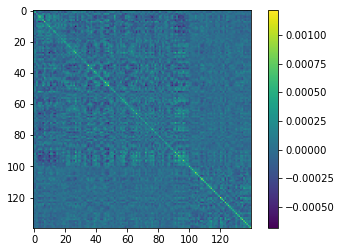

In [16]:

plt.imshow(mat)
plt.colorbar()
#plt.clim((-0.001,0.001))
plt.show()

#print(mat)

#print(mat[0,:])


In [17]:

npar_small = 0
cpar_small = np.zeros((L+1,))
for iL in np.arange(0,L):
    npar_small = npar_small + dim_small[iL] * dim_small[iL+1]
    cpar_small[iL+1] = npar_small

npar_small = npar_small.astype(int)
cpar_small = cpar_small.astype(int)

print(npar_small)
print(cpar_small)

evlinp, evc = np.linalg.eigh(mat[cpar_small[0]:cpar_small[1],cpar_small[0]:cpar_small[1]])
evlout, evc = np.linalg.eigh(mat[cpar_small[L-1]:cpar_small[L],cpar_small[L-1]:cpar_small[L]])

evl, evc = np.linalg.eigh(mat)


140
[  0 100 140]


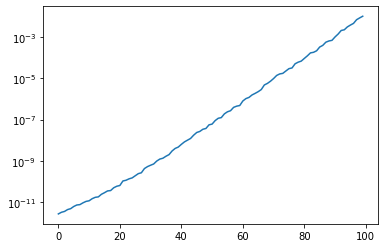

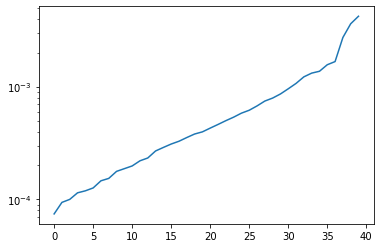

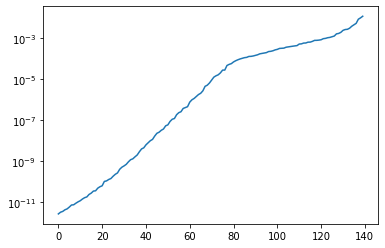

[0.0003547  0.0006243  0.00052551 0.00054369 0.00076869 0.00029369
 0.00084151 0.00090208 0.000309   0.00045047 0.00066955 0.00051173
 0.00022006 0.00061921 0.00048757 0.00035244 0.00028766 0.00026054
 0.00044918 0.00033385 0.00057802 0.00026214 0.00047717 0.0004928
 0.00031526 0.00022794 0.00071588 0.00090162 0.00032594 0.00032138
 0.00026646 0.0004239  0.00012977 0.00047034 0.00026584 0.0009723
 0.00033026 0.0006877  0.00028331 0.00067076 0.00057949 0.00023326
 0.00041259 0.00049978 0.00046106 0.00047203 0.00089571 0.00052977
 0.00095888 0.00027876 0.0004383  0.00041167 0.00061703 0.00015174
 0.00024418 0.00026928 0.00059997 0.00055449 0.00049371 0.00064144
 0.00049966 0.00033535 0.00020648 0.00049933 0.00057889 0.00029141
 0.00078999 0.00027187 0.00054684 0.0004949  0.00023136 0.00033015
 0.00073754 0.00035273 0.00017552 0.00035312 0.0007849  0.0004094
 0.00053773 0.0003205  0.0002563  0.00064599 0.00030261 0.00050188
 0.00025008 0.00061995 0.00024246 0.00041434 0.00028053 0.0004635

In [18]:

plt.plot(np.abs(evlinp))
plt.yscale('log')
plt.show()

plt.plot(np.abs(evlout))
plt.yscale('log')
plt.show()

plt.plot(np.abs(evl))
plt.yscale('log')
plt.show()

print(np.diag(mat[cpar_small[0]:cpar_small[1],cpar_small[0]:cpar_small[1]]))
print(np.diag(mat[cpar_small[L-1]:cpar_small[L],cpar_small[L-1]:cpar_small[L]]))


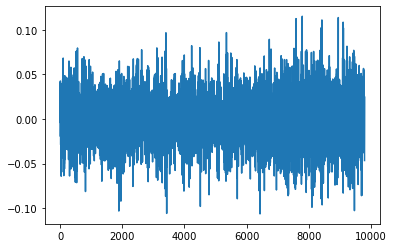

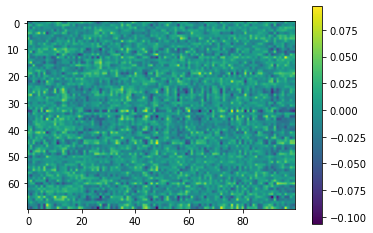

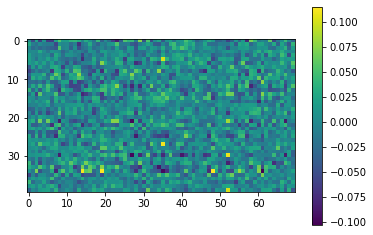

In [19]:

epoch = 0
inet = 0

plt.plot(grad_rec[:,epoch,inet])
plt.show()

for iL in range(L):
    plt.imshow(np.reshape(grad_rec[cpar[iL]:cpar[iL+1],epoch,inet],(dim[iL+1],dim[iL]),order='F'))
    #plt.clim((-1000,1000))
    plt.colorbar()
    plt.show()


In [21]:
# compare models

corravg = np.zeros((nepochs_gd,))
meanpar = np.zeros((nepochs_gd,))
for epoch in range(nepochs_gd):

    if L==2:
        allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+dim[0]*dim[2]))
    else:
        allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+L-2))

    for inet in range(num_models):
        allmodels[inet,0:dim[0]**2] = np.reshape(PHI1_rec[:,:,epoch,inet],(dim[0]**2,),order='F')
        allmodels[inet,dim[0]**2:(dim[0]**2+dim[L]**2)] = np.reshape(PHIL_rec[:,:,epoch,inet],(dim[L]**2,),order='F')
        if L==2:
            allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+dim[0]*dim[2])] = np.reshape(PSI1_rec[:,:,epoch,inet],(dim[0]*dim[L],),order='F')
        for iL in np.arange(1,L-1):
            allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+iL)] = phi_rec[iL-1,epoch,inet]

    corrmat = np.corrcoef(allmodels)
    
    np.fill_diagonal(corrmat, np.nan)
    corravg[epoch] = np.nanmean(corrmat)
    meanpar[epoch] = np.mean(allmodels)


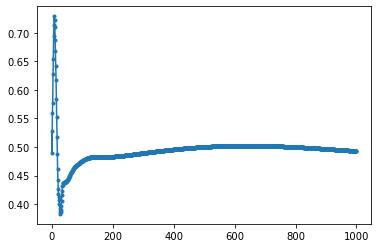

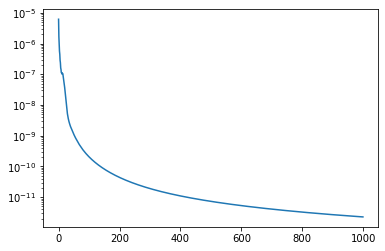

In [26]:

plt.plot(corravg,marker='.')
plt.show()

plt.plot(meanpar)
plt.yscale('log')
plt.show()


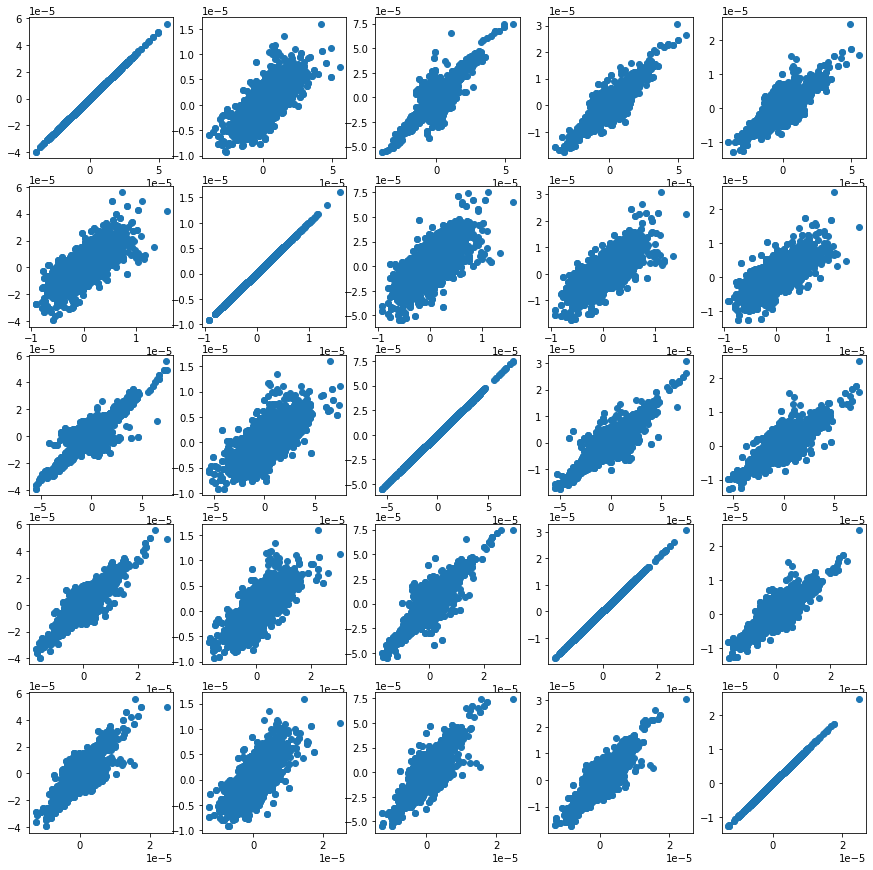

In [27]:

epoch = 7


if L==2:
    allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+dim[0]*dim[2]))
else:
    allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+L-2))

for inet in range(num_models):
    allmodels[inet,0:dim[0]**2] = np.reshape(PHI1_rec[:,:,epoch,inet],(dim[0]**2,),order='F')
    allmodels[inet,dim[0]**2:(dim[0]**2+dim[L]**2)] = np.reshape(PHIL_rec[:,:,epoch,inet],(dim[L]**2,),order='F')
    if L==2:
        allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+dim[0]*dim[2])] = np.reshape(PSI1_rec[:,:,epoch,inet],(dim[0]*dim[L],),order='F')
    for iL in np.arange(1,L-1):
        allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+iL)] = phi_rec[iL-1,epoch,inet]


fig, ax = plt.subplots(5,5)
fig.set_size_inches(15, 15)
for inet in range(5):
    for jnet in range(5):
        ax[inet,jnet].scatter(allmodels[inet,:],allmodels[jnet,:])
plt.show()



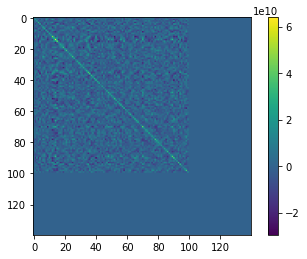

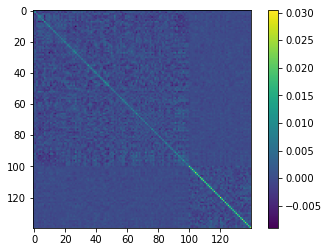

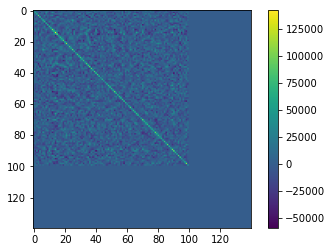

In [28]:

eps = 0.

evldamp, evc = np.linalg.eigh(mat+eps*np.eye(npar_small))

imat = (evc * 1/evldamp) @ evc.T

smat = (evc * np.sqrt(evldamp)) @ evc.T

ismat = (evc * 1/np.sqrt(evldamp)) @ evc.T


plt.imshow(imat)
plt.colorbar()
plt.show()

plt.imshow(smat)
plt.colorbar()
plt.show()

plt.imshow(ismat)
plt.colorbar()
plt.show()



### Momentum

In [73]:

beta = 0.98

phi_mom = np.zeros((L-2,nepochs_gd,num_models+1))
PHI1_mom = np.zeros((dim[0],dim[0],nepochs_gd,num_models+1))
PSI1_mom = np.zeros((dim[0],dim[2],nepochs_gd,num_models+1))
PHIL_mom = np.zeros((dim[L],dim[L],nepochs_gd,num_models+1))

phi_mom[:,0,:] = (1-beta) * phi_rec[:,0,:]
PHI1_mom[:,:,0,:] = (1-beta) * PHI1_rec[:,:,0,:]
PSI1_mom[:,:,0,:] = (1-beta) * PSI1_rec[:,:,0,:]
PHIL_mom[:,:,0,:] = (1-beta) * PHIL_rec[:,:,0,:]

for epoch in range(1,nepochs_gd):
    if epoch%(nepochs_gd/100) == 0:
        print(epoch)
    phi_mom[:,epoch,:] = beta * phi_mom[:,epoch-1,:] + (1-beta) * phi_rec[:,epoch,:]
    PHI1_mom[:,:,epoch,:] = beta * PHI1_mom[:,:,epoch-1,:] + (1-beta) * PHI1_rec[:,:,epoch,:]
    PSI1_mom[:,:,epoch,:] = beta * PSI1_mom[:,:,epoch-1,:] + (1-beta) * PSI1_rec[:,:,epoch,:]
    PHIL_mom[:,:,epoch,:] = beta * PHIL_mom[:,:,epoch-1,:] + (1-beta) * PHIL_rec[:,:,epoch,:]
    
for epoch in range(nepochs_gd):
    phi_mom[:,epoch,:] /= ( 1-beta**(epoch+1) )
    PHI1_mom[:,:,epoch,:] /= ( 1-beta**(epoch+1) )
    PSI1_mom[:,:,epoch,:] /= ( 1-beta**(epoch+1) )
    PHIL_mom[:,:,epoch,:] /= ( 1-beta**(epoch+1) )


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [74]:

eigrec = np.zeros((dim[0]+(L-2)+dim[L],nepochs_gd,num_models+1))
for epoch in range(nepochs_gd):
    if epoch%(nepochs_gd/100) == 0:
        print(epoch)
    for inet in range(num_models):
        eigrec[:,epoch,inet] = sm.eig_unique(L,dim,np.reshape(phi_mom[:,epoch,inet],(L-2,)),np.squeeze(PHI1_mom[:,:,epoch,inet]),np.squeeze(PSI1_mom[:,:,epoch,inet]),np.squeeze(PHIL_mom[:,:,epoch,inet]))
    eigrec[:,epoch,num_models] = sm.eig_unique(L,dim,np.reshape(phi_mom[:,epoch,num_models],(L-2,)),np.squeeze(PHI1_mom[:,:,epoch,num_models]),np.squeeze(PSI1_mom[:,:,epoch,num_models]),np.squeeze(PHIL_mom[:,:,epoch,num_models]))



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


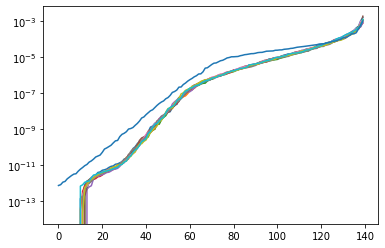

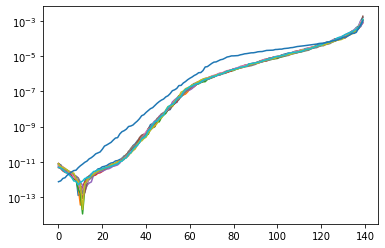

In [75]:

epoch = 20

for inet in range(num_models):
    plt.plot(eigrec[:,epoch,inet])
plt.plot(eigrec[:,epoch,num_models])
plt.yscale('log')
plt.show()

for inet in range(num_models):
    plt.plot(np.abs(eigrec[:,epoch,inet]))
plt.plot(np.abs(eigrec[:,epoch,num_models]))
plt.yscale('log')
plt.show()


In [76]:

# compare models

corravg = np.zeros((nepochs_gd,))
meanpar = np.zeros((nepochs_gd,))
for epoch in range(nepochs_gd):

    if L==2:
        allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+dim[0]*dim[2]))
    else:
        allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+L-2))

    for inet in range(num_models):
        allmodels[inet,0:dim[0]**2] = np.reshape(PHI1_mom[:,:,epoch,inet],(dim[0]**2,),order='F')
        allmodels[inet,dim[0]**2:(dim[0]**2+dim[L]**2)] = np.reshape(PHIL_mom[:,:,epoch,inet],(dim[L]**2,),order='F')
        if L==2:
            allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+dim[0]*dim[2])] = np.reshape(PSI1_mom[:,:,epoch,inet],(dim[0]*dim[L],),order='F')
        for iL in np.arange(1,L-1):
            allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+iL)] = phi_mom[iL-1,epoch,inet]

    corrmat = np.corrcoef(allmodels)
    
    np.fill_diagonal(corrmat, np.nan)
    corravg[epoch] = np.nanmean(corrmat)
    meanpar[epoch] = np.mean(allmodels)




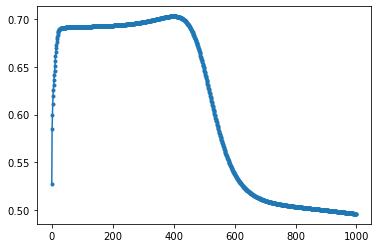

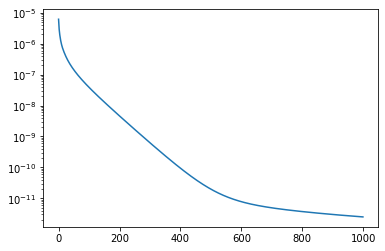

In [77]:

plt.plot(corravg,marker='.')
plt.show()

plt.plot(meanpar)
plt.yscale('log')
plt.show()



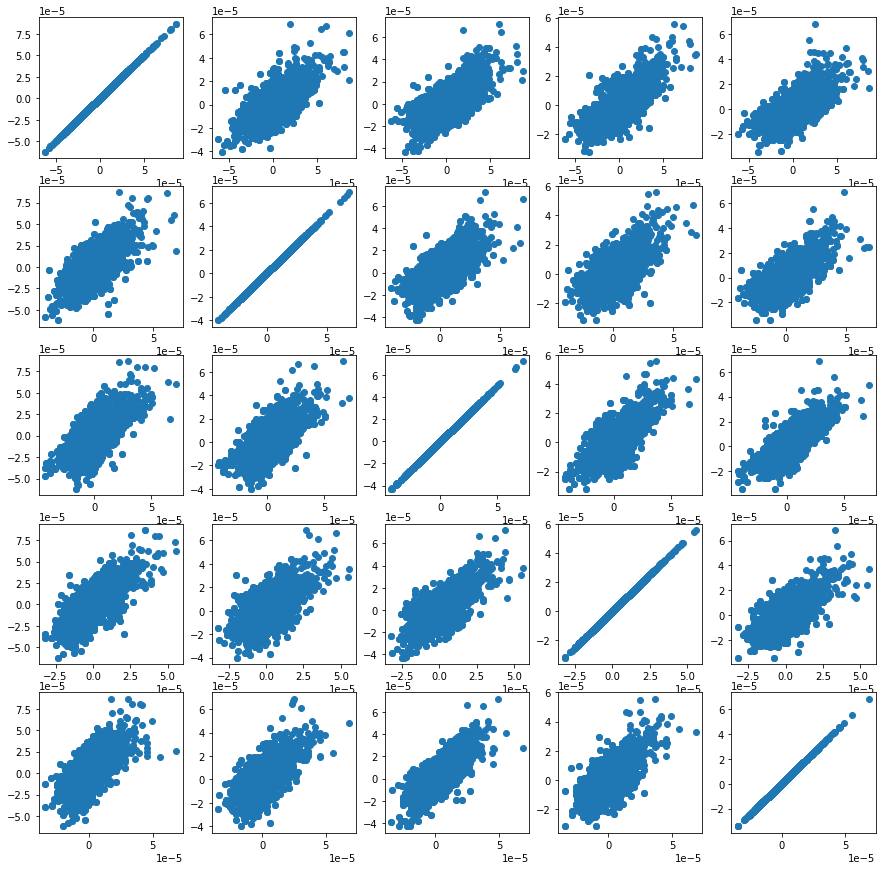

In [46]:


epoch = 20


if L==2:
    allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+dim[0]*dim[2]))
else:
    allmodels = np.zeros((num_models,dim[0]**2+dim[L]**2+L-2))

for inet in range(num_models):
    allmodels[inet,0:dim[0]**2] = np.reshape(PHI1_mom[:,:,epoch,inet],(dim[0]**2,),order='F')
    allmodels[inet,dim[0]**2:(dim[0]**2+dim[L]**2)] = np.reshape(PHIL_mom[:,:,epoch,inet],(dim[L]**2,),order='F')
    if L==2:
        allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+dim[0]*dim[2])] = np.reshape(PSI1_mom[:,:,epoch,inet],(dim[0]*dim[L],),order='F')
    for iL in np.arange(1,L-1):
        allmodels[inet,(dim[0]**2+dim[L]**2):(dim[0]**2+dim[L]**2+iL)] = phi_mom[iL-1,epoch,inet]


fig, ax = plt.subplots(5,5)
fig.set_size_inches(15, 15)
for inet in range(5):
    for jnet in range(5):
        ax[inet,jnet].scatter(allmodels[inet,:],allmodels[jnet,:])
plt.show()



In [78]:

#corravg_beta09 = np.copy(corravg)
#corravg_beta0 = np.copy(corravg)
#corravg_beta099 = np.copy(corravg)
#corravg_beta095 = np.copy(corravg)
#corravg_beta098 = np.copy(corravg)



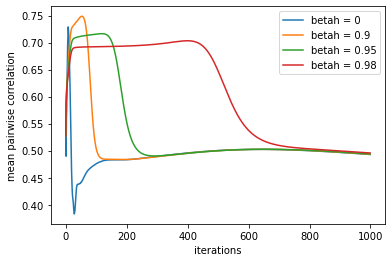

In [80]:

plt.plot(corravg_beta0,label='betah = 0')
plt.plot(corravg_beta09,label='betah = 0.9')
plt.plot(corravg_beta095,label='betah = 0.95')
plt.plot(corravg_beta098,label='betah = 0.98')
#plt.plot(corravg_beta099,label='betah = 0.99')
plt.legend()

plt.xlabel('iterations')
plt.ylabel('mean pairwise correlation')
#plt.savefig('momentum.pdf',bbox_inches="tight")

plt.show()






